<a href="https://colab.research.google.com/github/AnzhelikaKoldaeva/Autoencoders/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

Here, I implement 3 different types of autoencoders (linear, convolutional and variational) on the "lfw-deepfunneled" (http://vis-www.cs.umass.edu/lfw/) database of human faces. The original space of the images has the dimensionalily $128\times128\times3$. The latent space of the autoencoders is 40- (80- for the variational autoencoder) dimensional. 

Also, I implement cheap image morphing, using the latent coordinates (the code) of the images. 

I trained the networkes on a GPU in Google Colab. The trained weights are saved separately for each autoencoder and can be easily uploaded for further usage.

# Simple linear autoencoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi

Sun Feb 20 03:54:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.6.0

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
  Using cached tensorflow-2.6.0-cp37-cp37m-manylinux2010_x86_64.whl (458.3 MB)


In [ ]:
!pip uninstall keras -y
!pip install keras==2.6.0

Found existing installation: keras 2.7.0
Uninstalling keras-2.7.0:
  Successfully uninstalled keras-2.7.0
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import imageio
import random
import time


In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
print(tf.__version__)

2.6.0


Upload the data from the "lfw-deepfunneled" folder.

In [108]:
X_data = []

folder = '/content/drive/MyDrive/Deep_Learning/lfw-deepfunneled' #'lfw-deepfunneled'
#print(os.listdir(folder))
name_per = os.listdir(folder)[0]
print(name_per)
print(os.listdir(os.path.join(folder,name_per)))
for pers_fold in os.listdir(folder):
    curr_path_pers_fold = os.path.join(folder,pers_fold)
    if os.path.isdir(curr_path_pers_fold):
        for img_name in os.listdir(curr_path_pers_fold):
            curr_path_imag = os.path.join(curr_path_pers_fold,img_name)
            im = imageio.imread(curr_path_imag)
            X_data.append(im)
        


#im = imageio.imread(str("lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg"))
#im  = im.astype('float32')/255.

Gregg_Popovich
['Gregg_Popovich_0004.jpg', 'Gregg_Popovich_0001.jpg', 'Gregg_Popovich_0002.jpg', 'Gregg_Popovich_0003.jpg', 'Gregg_Popovich_0005.jpg']


KeyboardInterrupt: ignored

In [109]:
len(X_data)

2761

In [110]:
X_data = np.array(X_data)    
X_data.shape[:]

thresh = 64
X_data = X_data[:, 125-thresh:125+thresh, 125-thresh:125+thresh, : ]


X_data.shape[:]

(2761, 128, 128, 3)

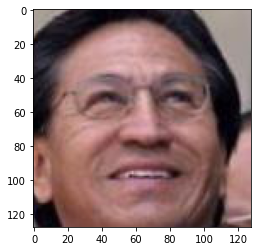

In [111]:
plt.imshow(X_data[16])

Here, I make two lists of the train ($80\%$) and the test ($20\%$) data.

In [112]:
x_train_ind = random.sample(range(len(X_data)), int(len(X_data)*0.8))
x_test_ind = list(set(range(len(X_data))) - set(x_train_ind))

x_train = X_data[x_train_ind]
x_test = X_data[x_test_ind]

In [113]:
print('training size = '+str(x_train.shape[:]))
print('test size = '+str(x_test.shape[:]))

training size = (2208, 128, 128, 3)
test size = (553, 128, 128, 3)


(128, 128, 3)


(2208, 128, 128, 3)

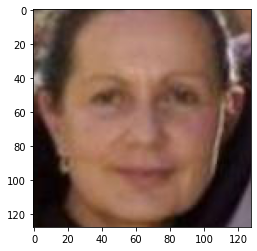

In [114]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
plt.imshow(x_train[10])
IMG_SHAPE = x_test.shape[1:]
print(IMG_SHAPE)
x_train.shape

#X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [115]:
#x_train = x_train.reshape((x_train.shape[0],-1))
#x_test = x_test.reshape((x_test.shape[0],-1))

Implement and train the linear autoencoder that consisits of one dense layer.

In [176]:
def linear_autoencoder(imag_shape, latent_size):
    encoder = keras.models.Sequential()
    encoder.add(keras.layers.InputLayer(imag_shape))
    encoder.add(keras.layers.Flatten())
    encoder.add(keras.layers.Dense(latent_size))
    encoder.summary()
    
    decoder = keras.models.Sequential()
    decoder.add(keras.layers.InputLayer(latent_size))
    decoder.add(keras.layers.Dense(np.prod(imag_shape)))
    decoder.add(keras.layers.Reshape(imag_shape))
    decoder.summary()
    return encoder, decoder

In [177]:
tf.keras.backend.clear_session()

latent_size = 40
encoder, decoder = linear_autoencoder(IMG_SHAPE, latent_size)

inp = keras.layers.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

linear_autoencoder = keras.models.Model(inputs = inp, outputs = reconstruction)
linear_autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 40)                1966120   
                                                                 
Total params: 1,966,120
Trainable params: 1,966,120
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 49152)             2015232   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
Total params: 2,015,232


Epoch 1/10
69/69 [==============================] - 2s 18ms/step - loss: 0.0892 - val_loss: 0.0371
Epoch 2/10
69/69 [==============================] - 1s 15ms/step - loss: 0.0318 - val_loss: 0.0305
Epoch 3/10
69/69 [==============================] - 2s 22ms/step - loss: 0.0246 - val_loss: 0.0232
Epoch 4/10
69/69 [==============================] - 1s 19ms/step - loss: 0.0217 - val_loss: 0.0217
Epoch 5/10
69/69 [==============================] - 1s 14ms/step - loss: 0.0201 - val_loss: 0.0210
Epoch 6/10
69/69 [==============================] - 1s 14ms/step - loss: 0.0182 - val_loss: 0.0179
Epoch 7/10
69/69 [==============================] - 1s 14ms/step - loss: 0.0192 - val_loss: 0.0170
Epoch 8/10
69/69 [==============================] - 1s 14ms/step - loss: 0.0158 - val_loss: 0.0158
Epoch 9/10
69/69 [==============================] - 1s 14ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 10/10
69/69 [==============================] - 1s 17ms/step - loss: 0.0138 - val_loss: 0.0140


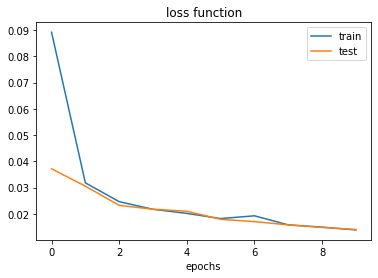

In [178]:
history = linear_autoencoder.fit(x = x_train, y = x_train, batch_size = 32, epochs = 10, validation_data = (x_test, x_test))
plt.plot(history.history['loss'], label = 'train ')
plt.plot(history.history['val_loss'], label = 'test ')
plt.title("loss function")
plt.xlabel("epochs")
plt.legend(['train', 'test'], loc='upper right')

In [180]:
encoder.save_weights('/content/drive/MyDrive/Deep_Learning/linear_encoder_weights.h5')
decoder.save_weights('/content/drive/MyDrive/Deep_Learning/linear_decoder_weights.h5')

In [181]:
encoder.load_weights('/content/drive/MyDrive/Deep_Learning/linear_encoder_weights.h5')
decoder.load_weights('/content/drive/MyDrive/Deep_Learning/linear_decoder_weights.h5')

In [119]:
decoded_imgs = linear_autoencoder.predict(x_test)

After training the autoencoder, I plot the results. Here, we can clearly see that the resulted reconstructed images are not precise enought due to simplicity of the autoencoder.

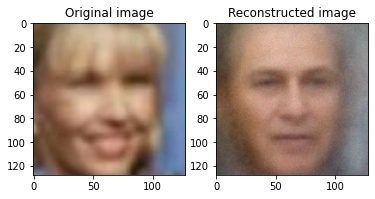

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


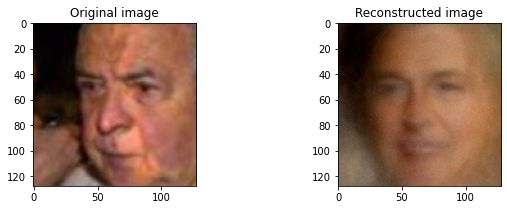

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


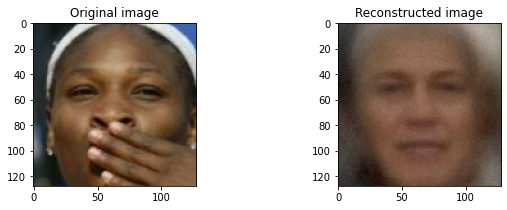

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


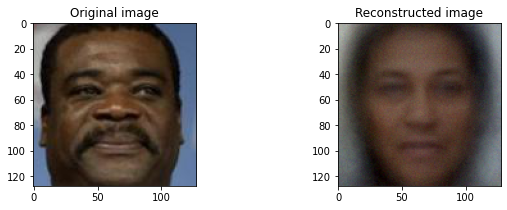

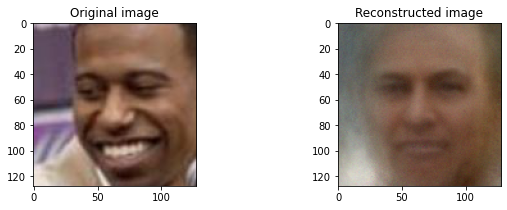

In [179]:
i = 20

def visualiz(img):
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original image")

    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]
    plt.subplot(1,2,2)
    plt.imshow(reco)
    plt.title("Reconstructed image")
    
    plt.show()

for i in random.sample(range(len(x_test)), 4):
    visualiz(x_test[i])
    plt.rcParams['figure.figsize'] = [10, 3]
    
    
visualiz(x_test[30]) 

I implement cheap image morphing using the latent space coordinates of two images. Here, I introduce the parameter  $0\leq \alpha \leq 1$  as the weight for the first image. In other words, resut = $\alpha *$ image1 + $(1-\alpha) *$ image2. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


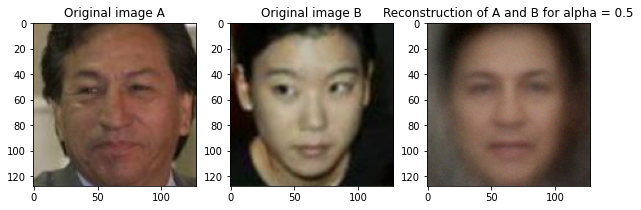

In [184]:
k = 12
l = 20

plt.subplot(1,3,1)
plt.imshow(x_test[k])
plt.title("Original image A")

plt.subplot(1,3,2)
plt.imshow(x_test[l])
plt.title("Original image B")

alpha = 0.5


plt.subplot(1,3,3)
code1, code2 = encoder.predict(np.stack([x_test[k], x_test[l]]))
new_code = alpha*code1+(1-alpha)*code2
reconstr = decoder.predict(new_code[None])[0]
plt.imshow(reconstr)
plt.title("Reconstruction of A and B for alpha = "+str(alpha))

plt.rcParams['figure.figsize'] = [10, 3]


# Convolutional autoencoder

Next, I implement and train a convolutional autoencoder.

In [122]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [123]:
def convolutional_autoencoder(imag_shape, latent_size):
    encoder = keras.models.Sequential()
    encoder.add(keras.layers.InputLayer(imag_shape))
    
    encoder.add(keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    encoder.add(keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

    encoder.add(keras.layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

    encoder.add(keras.layers.Conv2D(254, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    encoder.add(keras.layers.Flatten())
    encoder.add(keras.layers.Dense(latent_size))
    encoder.summary()
    
    decoder = keras.models.Sequential()
    decoder.add(keras.layers.InputLayer(latent_size))
    
    decoder.add(keras.layers.Dense(8*8*254))
    decoder.add(keras.layers.Reshape((8,8,254)))
                
    decoder.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
               
                
                

    decoder.summary()
    return encoder, decoder

In [124]:
tf.keras.backend.clear_session()

latent_size = 40
encoder, decoder = convolutional_autoencoder(IMG_SHAPE, latent_size)

inp = keras.layers.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

convolutional_autoencoder = keras.models.Model(inputs = inp, outputs = reconstruction)
convolutional_autoencoder.compile(optimizer = 'adamax', loss = 'mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

Epoch 1/25
69/69 [==============================] - 8s 101ms/step - loss: 0.0615 - val_loss: 0.0290
Epoch 2/25
69/69 [==============================] - 6s 92ms/step - loss: 0.0254 - val_loss: 0.0236
Epoch 3/25
69/69 [==============================] - 6s 92ms/step - loss: 0.0208 - val_loss: 0.0197
Epoch 4/25
69/69 [==============================] - 6s 92ms/step - loss: 0.0183 - val_loss: 0.0179
Epoch 5/25
69/69 [==============================] - 6s 92ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 6/25
69/69 [==============================] - 6s 92ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 7/25
69/69 [==============================] - 6s 92ms/step - loss: 0.0143 - val_loss: 0.0147
Epoch 8/25
69/69 [==============================] - 6s 92ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 9/25
69/69 [==============================] - 6s 92ms/step - loss: 0.0126 - val_loss: 0.0128
Epoch 10/25
69/69 [==============================] - 6s 92ms/step - loss: 0.0118 - val_loss: 0.0123
Epoch 11

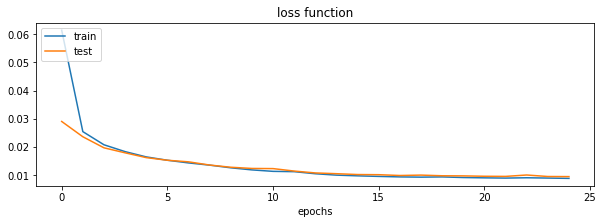

In [125]:
history = convolutional_autoencoder.fit(x = x_train, y = x_train, batch_size = 32, epochs = 25, validation_data = (x_test, x_test))
plt.plot(history.history['loss'], label = 'train ')
plt.plot(history.history['val_loss'], label = 'test ')
plt.title("loss function")
plt.xlabel("epochs")
plt.legend(['train', 'test'], loc='upper left')

In [126]:
encoder.save_weights('/content/drive/MyDrive/Deep_Learning/convolut_encoder_weights.h5')
decoder.save_weights('/content/drive/MyDrive/Deep_Learning/convolut_decoder_weights.h5')

In [127]:
encoder.load_weights('/content/drive/MyDrive/Deep_Learning/convolut_encoder_weights.h5')
decoder.load_weights('/content/drive/MyDrive/Deep_Learning/convolut_decoder_weights.h5')

The reconstructed images of the convolutional autoencoder are closer to the original ones.

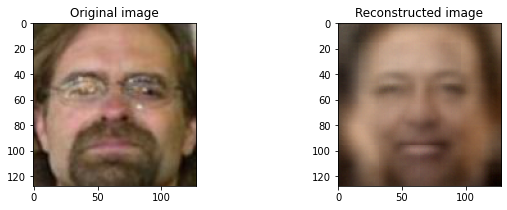

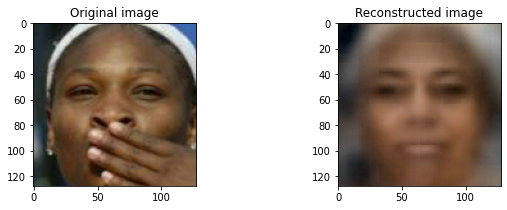

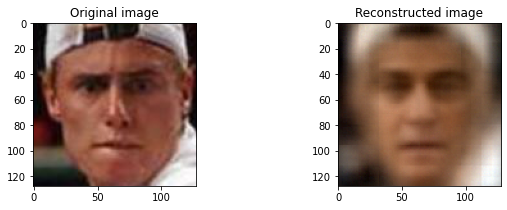

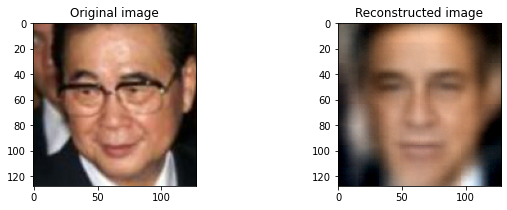

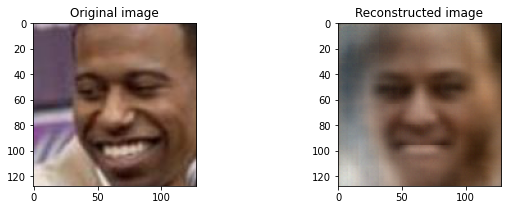

In [128]:
i = 20

def show_image(x):
    plt.imshow(np.clip(x, 0, 1))

def visualiz(img):
    plt.subplot(1,2,1)
    show_image(img)
    plt.title("Original image")

    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]
    plt.subplot(1,2,2)
    show_image(reco)
    plt.title("Reconstructed image")
    
    plt.show()

for i in random.sample(range(len(x_test)), 4):
    visualiz(x_test[i])
    plt.rcParams['figure.figsize'] = [10, 3]
    
    
visualiz(x_test[30]) 

# Image morphing

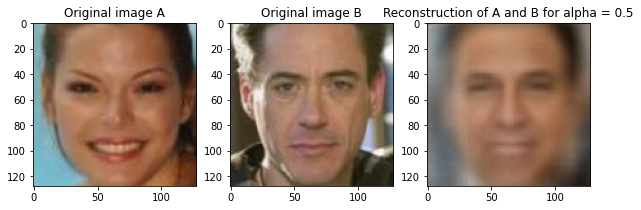

In [139]:
k = 35  #568 
l = 40

plt.subplot(1,3,1)
show_image(x_test[k])
plt.title("Original image A")

plt.subplot(1,3,2)
show_image(x_test[l])
plt.title("Original image B")

alpha = 0.5


plt.subplot(1,3,3)
code1, code2 = encoder.predict(np.stack([x_test[k], x_test[l]]))
new_code = alpha*code1+(1-alpha)*code2
reconstr = decoder.predict(new_code[None])[0]
show_image(reconstr)
plt.title("Reconstruction of A and B for alpha = "+str(alpha))

plt.rcParams['figure.figsize'] = [10, 3]
    

    

([], <a list of 0 Text major ticklabel objects>)

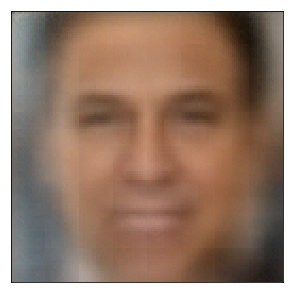

In [141]:
fig, ax = plt.subplots(figsize=(5,5))
image = ax.matshow(np.clip(reconstr, 0, 1))
plt.xticks([])
plt.yticks([])

In [142]:
import seaborn as sns
num_frames = 100

def drawframe(n):
    alpha = n/num_frames
    new_code = alpha*code1+(1-alpha)*code2
    reconstr = decoder.predict(new_code[None])[0]
    image.set_array(np.clip(reconstr, 0, 1))
    return (image,) 


from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=40)

In [143]:
from IPython.display import HTML
HTML(anim.to_html5_video())

Also, I implemented the tSNE clustering on the latent space.

In [144]:
from sklearn.manifold import TSNE

In [145]:
tsne = TSNE(n_components=2, perplexity=10, learning_rate=10, n_iter=1000)

In [146]:
coded_imgs = encoder(x_test)
coded_imgs.shape[:]
#np.savetxt('coded_imgs.txt',coded_imgs,delimiter='\t')

TensorShape([553, 40])

In [148]:
intermediates_tsne = tsne.fit_transform(array)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [149]:
a = np.transpose(intermediates_tsne)
a.shape[:]


(2, 553)

In [150]:
%matplotlib inline

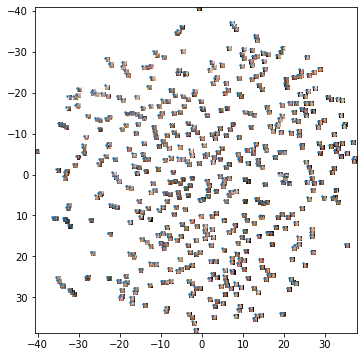

In [151]:
plt.figure(figsize = (6,6))

for i in range(len(x_test)): #i = 10
    extents = (a[0][i], a[0][i]+1, a[1][i]+1, a[1][i])
    plt.imshow(x_test[i], extent=extents)
plt.scatter(a[0], a[1], s = 2)
plt.show()

There are some visible clusters of images in the tSNE space, however, the combination of the convolutional autoencoder and tSNE doesn't result in good clustering of the images. Therefore, we implement a variational autoencoder and see how the visualization of the tSNE space changes.


# Variational autoencoders

In [188]:
def sampling(mean, log_var):
    #input_1,input_2 = param
    epsilon = tf.keras.backend.random_normal(shape=mean.shape[:], mean=0., stddev=1.)
    return mean + tf.keras.backend.exp(log_var / 2) * epsilon
    
    
    #mean = keras.Input(shape=input_1.shape[:])
    #log_var = keras.Input(shape=input_2.shape[:])
    #out = keras.layers.Lambda(sampling_reparameterization)([mean, log_var]) 
    #enc_2 = tf.keras.Model([mean,log_var], out)
    #return out #enc_2


In [189]:
def sampling_reparameterization(distribution_params):
    mean, log_var = distribution_params
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mean), mean=0., stddev=1.)
    z = mean + tf.keras.backend.exp(log_var / 2) * epsilon
    return z

In [190]:
IMG_SHAPE

(128, 128, 3)

In [191]:
def variational_autoencoder(imag_shape, latent_size):
    encoder = keras.models.Sequential()
    encoder.add(keras.layers.InputLayer(imag_shape))
    
    encoder.add(keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    encoder.add(keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

    encoder.add(keras.layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

    encoder.add(keras.layers.Conv2D(254, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    encoder.add(keras.layers.Flatten())
    encoder.add(keras.layers.Dense(latent_size+latent_size))
    encoder.summary()
    
    decoder = keras.models.Sequential()
    decoder.add(keras.layers.InputLayer(latent_size))
    
    decoder.add(keras.layers.Dense(8*8*254))
    decoder.add(keras.layers.Reshape((8,8,254)))
                
    decoder.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
               
          
            
            
            
    
    #encoder = keras.models.Sequential()
    #encoder.add(keras.layers.InputLayer(imag_shape))

    #encoder.add(keras.layers.Conv2D(32, kernel_size = (3,3), strides=2, padding = 'same', activation = 'relu'))
    #encoder.add(keras.layers.BatchNormalization())
    #encoder.add(keras.layers.LeakyReLU())    
    
    #encoder.add(keras.layers.Conv2D(64, kernel_size = (3,3), strides=2, padding = 'same', activation = 'relu'))
    #encoder.add(keras.layers.BatchNormalization())
    
    #encoder.add(keras.layers.Conv2D(128, kernel_size = (3,3), strides=2, padding = 'same', activation = 'relu'))
    #encoder.add(keras.layers.BatchNormalization())
    
    #encoder.add(keras.layers.Conv2D(254, kernel_size = (3,3), strides=2, padding = 'same', activation = 'relu'))
    #encoder.add(keras.layers.BatchNormalization())
    #encoder.add(keras.layers.LeakyReLU())
    #encoder.add(keras.layers.Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    #encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    #encoder.add(keras.layers.Conv2D(32, kernel_size = (3,3), strides=2, padding = 'same', activation = 'relu'))
    #encoder.add(keras.layers.BatchNormalization())
    #encoder.add(keras.layers.LeakyReLU())
    #encoder.add(keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    #encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

    #encoder.add(keras.layers.Conv2D(128, kernel_size = (3,3), padding = 'same'))#, activation = 'elu'))
    #encoder.add(keras.layers.BatchNormalization())
    #encoder.add(keras.layers.LeakyReLU())
    #encoder.add(keras.layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    #encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

    #encoder.add(keras.layers.Conv2D(254, kernel_size = (3,3), padding = 'same'))#, activation = 'elu'))
    #encoder.add(keras.layers.BatchNormalization())
    #encoder.add(keras.layers.LeakyReLU())
    #encoder.add(keras.layers.Conv2D(254, kernel_size = (3,3), padding = 'same', activation = 'elu'))
    #encoder.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    #encoder.add(keras.layers.Flatten())
    #encoder.add(keras.layers.Dense(latent_size+latent_size))
    #encoder.add(keras.layers.BatchNormalization())
    
    
    #flatten = layers.Flatten()(x)
    #mean = layers.Dense(latent_size, name='mean')(flatten)
    #log_var = layers.Dense(latent_size, name='log_var')(flatten)
    #model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    
    

    #mean = layers.Dense(2)(flatten)
    #log_var = layers.Dense(2)(flatten)
    #encoder.add((mean, log_var))
    #encoder.summary()
    
    #decoder = keras.models.Sequential()
    #decoder.add(keras.layers.InputLayer(latent_size))
    
    #decoder.add(keras.layers.Dense(8*8*254))
    #decoder.add(keras.layers.BatchNormalization())
    #decoder.add(keras.layers.Reshape((8,8,254)))
                
    #decoder.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='elu'))
    #decoder.add(keras.layers.BatchNormalization())
    #decoder.add(keras.layers.LeakyReLU())
    
    #decoder.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='relu'))
    
    #decoder.add(keras.layers.BatchNormalization())
    #decoder.add(keras.layers.LeakyReLU())
    
    #decoder.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding='same' , activation='relu'))
    #decoder.add(keras.layers.BatchNormalization())
    #decoder.add(keras.layers.LeakyReLU())
    
    #decoder.add(keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='sigmoid'))
    #decoder.add(keras.layers.BatchNormalization())
    #decoder.add(keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, padding='same', activation='sigmoid'))
            
    #outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    #model = tf.keras.Model(inputs, outputs, name="Decoder")
    
    decoder.summary()
    return encoder, decoder
    
    
    #encoder.add(keras.layers.Dense(latent_size))
    

In [192]:
tf.keras.backend.clear_session()

latent_size = 40
encoder, decoder = variational_autoencoder(IMG_SHAPE, latent_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [193]:
optimizer = tf.keras.optimizers.Adam()

def mse_loss(y_true, y_pred):
    r_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss =  -0.5 * tf.keras.backend.sum(1 + log_var - tf.keras.backend.square(mean) - tf.keras.backend.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred, mean, var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss1 = kl_loss(mean, var)
    return  r_loss + kl_loss1


In [204]:
tf.keras.backend.clear_session()

@tf.function
def train_step(images):
    with tf.GradientTape() as tp1, tf.GradientTape() as tp2:

        #print(0)
        encoder_out = encoder(images, training=True)
        #print("encoder_out = ")
        #print(encoder_out)
        mean = encoder_out[:,:latent_size]
        #print(2)
        log_var = encoder_out[:,latent_size:]
        #print(3)
        #print(log_var)
        #print(mean.shape[:])
        #print(log_var.shape[:])
        #print(mean)
        #print("log_var = ")
        #print(log_var)


        latent = sampling(mean, log_var)
        #print("latent = ")
        #print(latent)
        generated_images = decoder(latent, training=True)
        #print(5)
        loss_v = vae_loss(images, generated_images, mean, log_var)
        #print(6)
    
    
    gradients_enc = tp1.gradient(loss_v, encoder.trainable_variables)
    gradients_dec = tp2.gradient(loss_v, decoder.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_enc, encoder.trainable_variables))
    optimizer.apply_gradients(zip(gradients_dec, decoder.trainable_variables))
    
    return loss_v

In [205]:
#encoder_out = encoder(x_train[:2000], training=True)

Begin the epoch
Time for epoch 1 is 6.0902 sec
Begin the epoch
Time for epoch 2 is 4.6475 sec
Begin the epoch
Time for epoch 3 is 4.5843 sec
Begin the epoch
Time for epoch 4 is 4.6267 sec
Begin the epoch
Time for epoch 5 is 4.5675 sec
Begin the epoch
Time for epoch 6 is 4.6301 sec
Begin the epoch
Time for epoch 7 is 4.5477 sec
Begin the epoch
Time for epoch 8 is 4.6166 sec
Begin the epoch
Time for epoch 9 is 4.5674 sec
Begin the epoch
Time for epoch 10 is 4.6206 sec
Begin the epoch
Time for epoch 11 is 4.5689 sec
Begin the epoch
Time for epoch 12 is 4.6245 sec
Begin the epoch
Time for epoch 13 is 4.5533 sec
Begin the epoch
Time for epoch 14 is 4.6062 sec
Begin the epoch
Time for epoch 15 is 4.5564 sec
Begin the epoch
Time for epoch 16 is 4.6076 sec
Begin the epoch
Time for epoch 17 is 4.5543 sec
Begin the epoch
Time for epoch 18 is 4.6164 sec
Begin the epoch
Time for epoch 19 is 4.5603 sec
Begin the epoch
Time for epoch 20 is 4.6155 sec


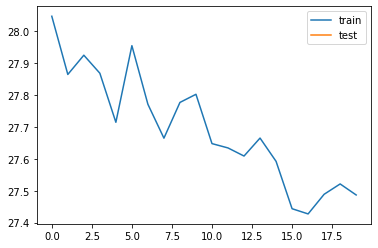

In [206]:
num_batch = int(len(x_train)/32)
dataset = [x_train[bid*32:(bid+1)*32] for bid in range(num_batch)]
tot_start_time = time.time()

def train(dataset, epochs):
    if (time.time() - tot_start_time)/60 < 2:
        train_loss = []
        valid_loss = []
        for epoch in range(epochs):
            print ('Begin the epoch')
            start = time.time()
            count = 0
            batch_train_loss = []
            batch_valid_loss = []
            for image_batch in dataset:
              count = count+1
              #print('Training '+str(count)+'/'+str(num_batch))

              loss_v = train_step(image_batch)
              #loss_v_norm = tf.reduce_sum(loss_v).numpy() #tf.reduce_mean(tf.reduce_sum(loss_v, axis=1))# tf.norm(loss_v)
              batch_train_loss.append(loss_v)#(loss_v_norm)
              
              #encoder_out = encoder(x_test)
              #mean = encoder_out[:,:latent_size]
              #log_var = encoder_out[:,latent_size:]

              #latent = sampling(mean, log_var)
              #generated_images_test = decoder(latent)
              #loss_v_test = vae_loss(x_test, generated_images_test, mean, log_var)        
              #batch_valid_loss.append(loss_v_test)#tf.reduce_sum(loss_v_test).numpy())
              
            print ('Time for epoch {} is {} sec'.format(epoch + 1, round((time.time()-start),4)))
            train_loss.append(tf.reduce_mean(batch_train_loss).numpy())
            #valid_loss.append(tf.reduce_mean(batch_valid_loss).numpy())
    else:
        encoder.save_weights('/content/drive/MyDrive/Deep_Learning/variat_encoder_weights.h5')
        decoder.save_weights('/content/drive/MyDrive/Deep_Learning/variat_decoder_weights.h5')

    return train_loss, valid_loss
       


train_loss, valid_loss = train(dataset, 20)

plt.plot(train_loss, label = 'train')
plt.plot(valid_loss, label = 'test')
plt.legend()


In [207]:
encoder.save_weights('/content/drive/MyDrive/Deep_Learning/variat_encoder_weights.h5')
decoder.save_weights('/content/drive/MyDrive/Deep_Learning/variat_decoder_weights.h5')

#enco = encoder.save('/content/drive/MyDrive/Deep_Learning')
#deco = decoder.save('/content/drive/MyDrive/Deep_Learning')

In [208]:
encoder.load_weights('/content/drive/MyDrive/Deep_Learning/variat_encoder_weights.h5')
decoder.load_weights('/content/drive/MyDrive/Deep_Learning/variat_decoder_weights.h5')

#encoder = keras.models.load_model('/content/drive/MyDrive/Deep_Learning/')

In [209]:
#i=10
#img = x_test[i]
#param = encoder.predict(img[None])[0]
#print(param)
#m = param[:latent_size]
#v = param[latent_size:]
#latent = sampling(m,v)
#print(latent)
#reconst = decoder.predict(latent[None])[0]
#print(reconst*255)
    #reco = decoder.predict(code[None])[0]
#plt.subplot(1,2,2)
#show_image(reconst)
#print(reconst)
#plt.title("Reconstructed image")

The results look better compare to the linear and convolutional autoencoders. However, they can be definitely improved by training the network for longer time or optimizing its architecture.

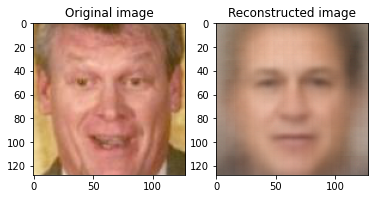

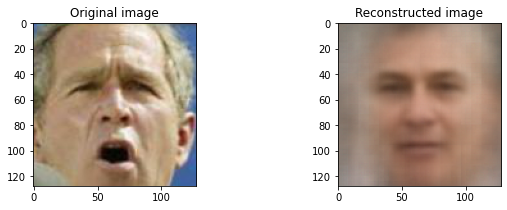

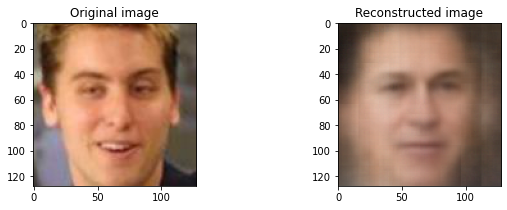

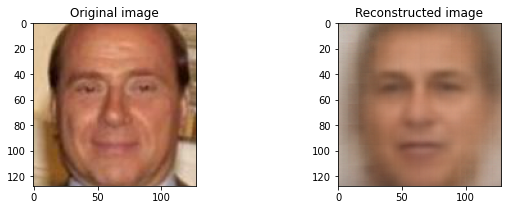

In [210]:
def show_image(x):
    plt.imshow(np.clip(x, 0, 1))

def visualiz(img):
    plt.subplot(1,2,1)
    show_image(img)
    plt.title("Original image")

    param = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    m = param[:latent_size]
    v = param[latent_size:]
    latent = sampling(m,v)
    reconst = decoder.predict(latent[None])[0]
    #reco = decoder.predict(code[None])[0]
    plt.subplot(1,2,2)
    show_image(reconst)
    plt.title("Reconstructed image")
    
    plt.show()

for i in random.sample(range(len(x_test)), 4):
    visualiz(x_test[i])
    plt.rcParams['figure.figsize'] = [10, 3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5, 128, 128, 3)


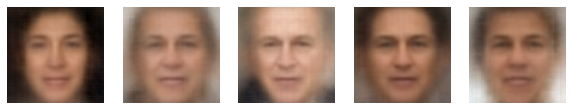

In [211]:

enc_out = encoder.predict(x_test[20:25])
m = enc_out[:,:latent_size]
v = enc_out[:,latent_size:]

latent = sampling(m,v)
reconst = decoder.predict(latent)
print(reconst.shape[:])

fig = plt.figure()

for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)

    ax.axis('off')
    ax.imshow(reconst[i, :,:,:], cmap = 'gray')


Next, I implement tSNE dimensionality reduction and visualization. The result looks much better than for the convolutional autoencoder!

In [212]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=10, learning_rate=10, n_iter=1000)

In [213]:
coded_imgs = encoder(x_test[:1000])
coded_imgs.shape[:]
array = coded_imgs.numpy()

In [214]:
intermediates_tsne = tsne.fit_transform(array)
a = np.transpose(intermediates_tsne)
a.shape[:]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


(2, 553)

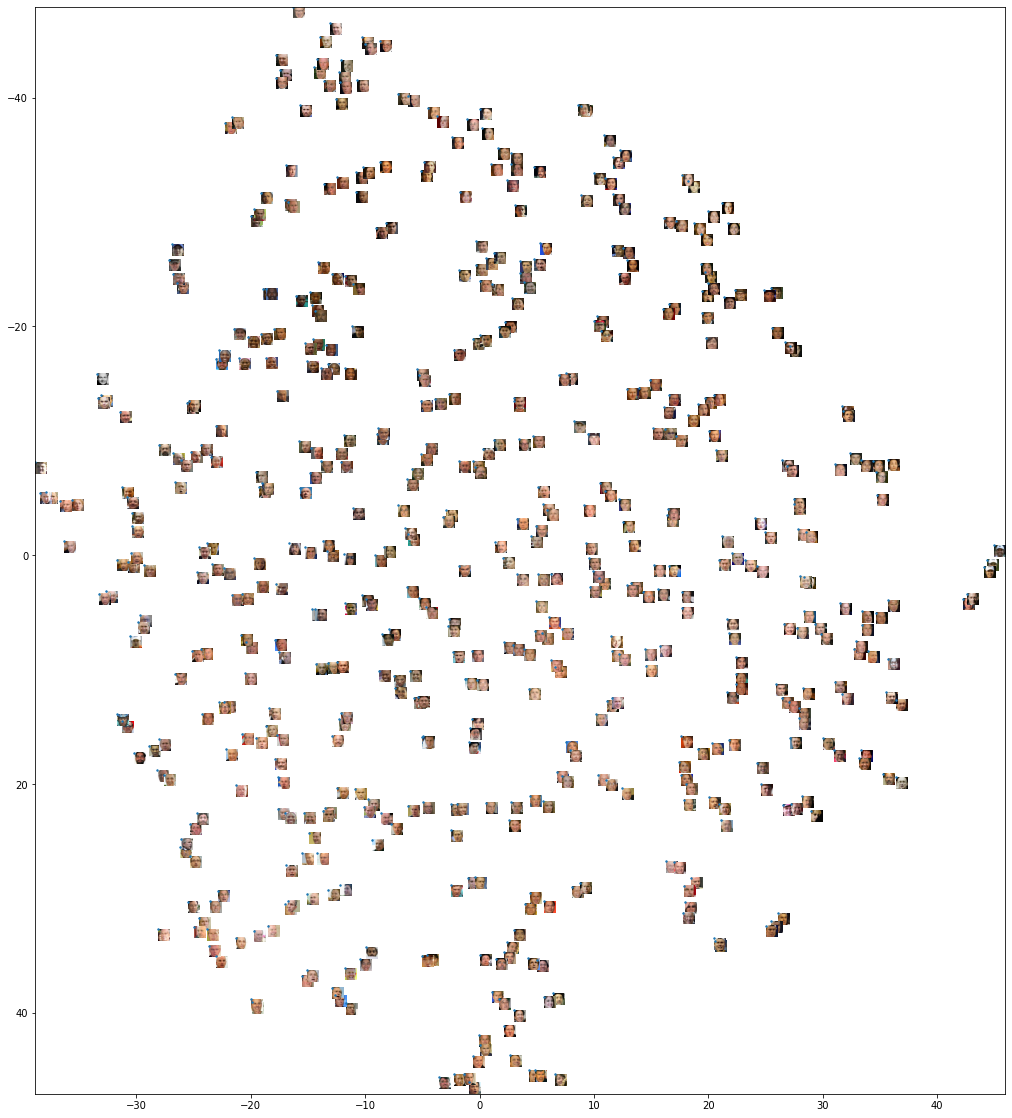

In [215]:
%matplotlib inline
plt.figure(figsize = (20,20))

for i in range(len(x_test[:1000])): #i = 10
    extents = (a[0][i], a[0][i]+1, a[1][i]+1, a[1][i])
    plt.imshow(x_test[i], extent=extents)
plt.scatter(a[0], a[1], s = 2)
plt.show()

We see clustering of the similar images!

[ 9.38812122e-02 -1.91239081e-02 -8.04449543e-02 -6.56987354e-02
 -1.08770907e-01 -1.11227972e-03 -1.37758955e-01 -3.88921835e-02
  7.25717517e-03 -3.56529951e-01  2.32634265e-02 -1.29191875e-01
 -6.02987222e-03 -2.00851588e-04 -4.74527217e-02  1.40738428e-01
  3.67703103e-03  5.76108731e-02  7.21968830e-01 -4.93927822e-02
 -1.06340654e-01  4.91268754e-01  1.70147613e-01  1.15581229e-03
 -2.59945225e-02 -1.39142890e-02  7.03287078e-04  7.41049126e-02
  5.39810136e-02  1.61692165e-02  4.03517783e-02  9.59753618e-02
  9.32261068e-03 -3.04293800e-02 -1.12082578e-01 -8.20709646e-01
 -1.24483138e-01  5.47552109e-02  4.11676243e-02 -4.05093044e-01]


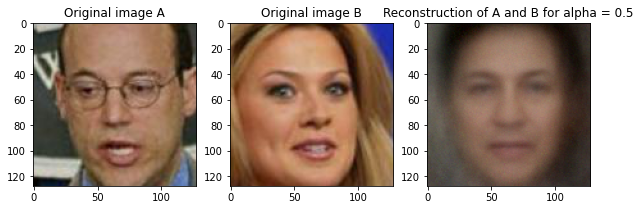

In [228]:
k = 54  #568 
l = 2

alpha = 0.5


plt.subplot(1,3,1)
show_image(x_test[k])
plt.title("Original image A")

plt.subplot(1,3,2)
show_image(x_test[l])
plt.title("Original image B")

code1, code2 = encoder.predict(np.stack([x_test[k], x_test[l]]))
m1 = code1[:latent_size]
v1 = code1[latent_size:]

m2 = code2[:latent_size]
v2 = code2[latent_size:]

plt.subplot(1,3,3)

m = alpha*m1+(1-alpha)*m2
v = alpha*v1+(1-alpha)*v2

latent = sampling(m,v)
reconst = decoder.predict(latent[None])[0]

show_image(reconstr)
plt.title("Reconstruction of A and B for alpha = "+str(alpha))

plt.rcParams['figure.figsize'] = [10, 3]
    


Also, using the autoencoders, we can generate a face that never existed by random sampling a point in the latent space and decoding it using the trained network.

[0.7562104  0.9277661  0.00462774 0.8952301  0.80090135 0.6890053
 0.52540976 0.4381361  0.00112847 0.91543394 0.12533599 0.37528554
 0.00802918 0.09725723 0.22092378 0.95268023 0.7952201  0.5751537
 0.412481   0.7574665  0.8537406  0.4670505  0.57007426 0.51990753
 0.7528032  0.56479174 0.9108316  0.07242154 0.71265733 0.30291888
 0.8133745  0.8729757  0.9347278  0.06824924 0.4582905  0.02173628
 0.2906091  0.17052503 0.23486313 0.16124693]


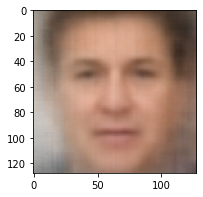

In [255]:
m = np.array([random.random() for x in range(latent_size)])
v = np.array([random.random() for x in range(latent_size)])

m = m.astype('float32')
v = v.astype('float32')

print(m)

latent = sampling(m,v)
reconst_n = decoder.predict(latent[None])[0]

show_image(reconst_n)